# Capital Bike Share Data Exploration

## Background

**Goal**: Predict bike usage across time using regression models

**Available Data**:

- X: 
    - datetime - hourly date + timestamp  
    - season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
    - holiday - whether the day is considered a holiday
    - workingday - whether the day is neither a weekend nor holiday
    - weather 
        - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
        - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
        - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    - temp - temperature in Celsius
    - atemp - "feels like" temperature in Celsius
    - humidity - relative humidity
    - windspeed - wind speed
- Y: 
    - casual - number of non-registered user rentals initiated
    - registered - number of registered user rentals initiated
    - **count - number of total rentals**

## First Steps:

- Read data
- Check for:
    - Types
    - Completeness
    - Correlation / Co-linearity

In [394]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read Data

In [395]:
path_data = "../01_data/train.csv"
rentals = pd.read_csv(path_data)
rentals['datetime'] = pd.to_datetime(rentals['datetime'])

## QC Checks

In [396]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [397]:
rentals.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [398]:
rentals.isna().sum().sum(), rentals.isnull().sum().sum()

(0, 0)

In [399]:
print(rentals.weather.value_counts())

# flatten type 4 into type 3

rentals.weather = rentals.weather.replace(4, 3)

print(rentals.weather.value_counts())



1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64
1    7192
2    2834
3     860
Name: weather, dtype: int64


## EDA

### Visual

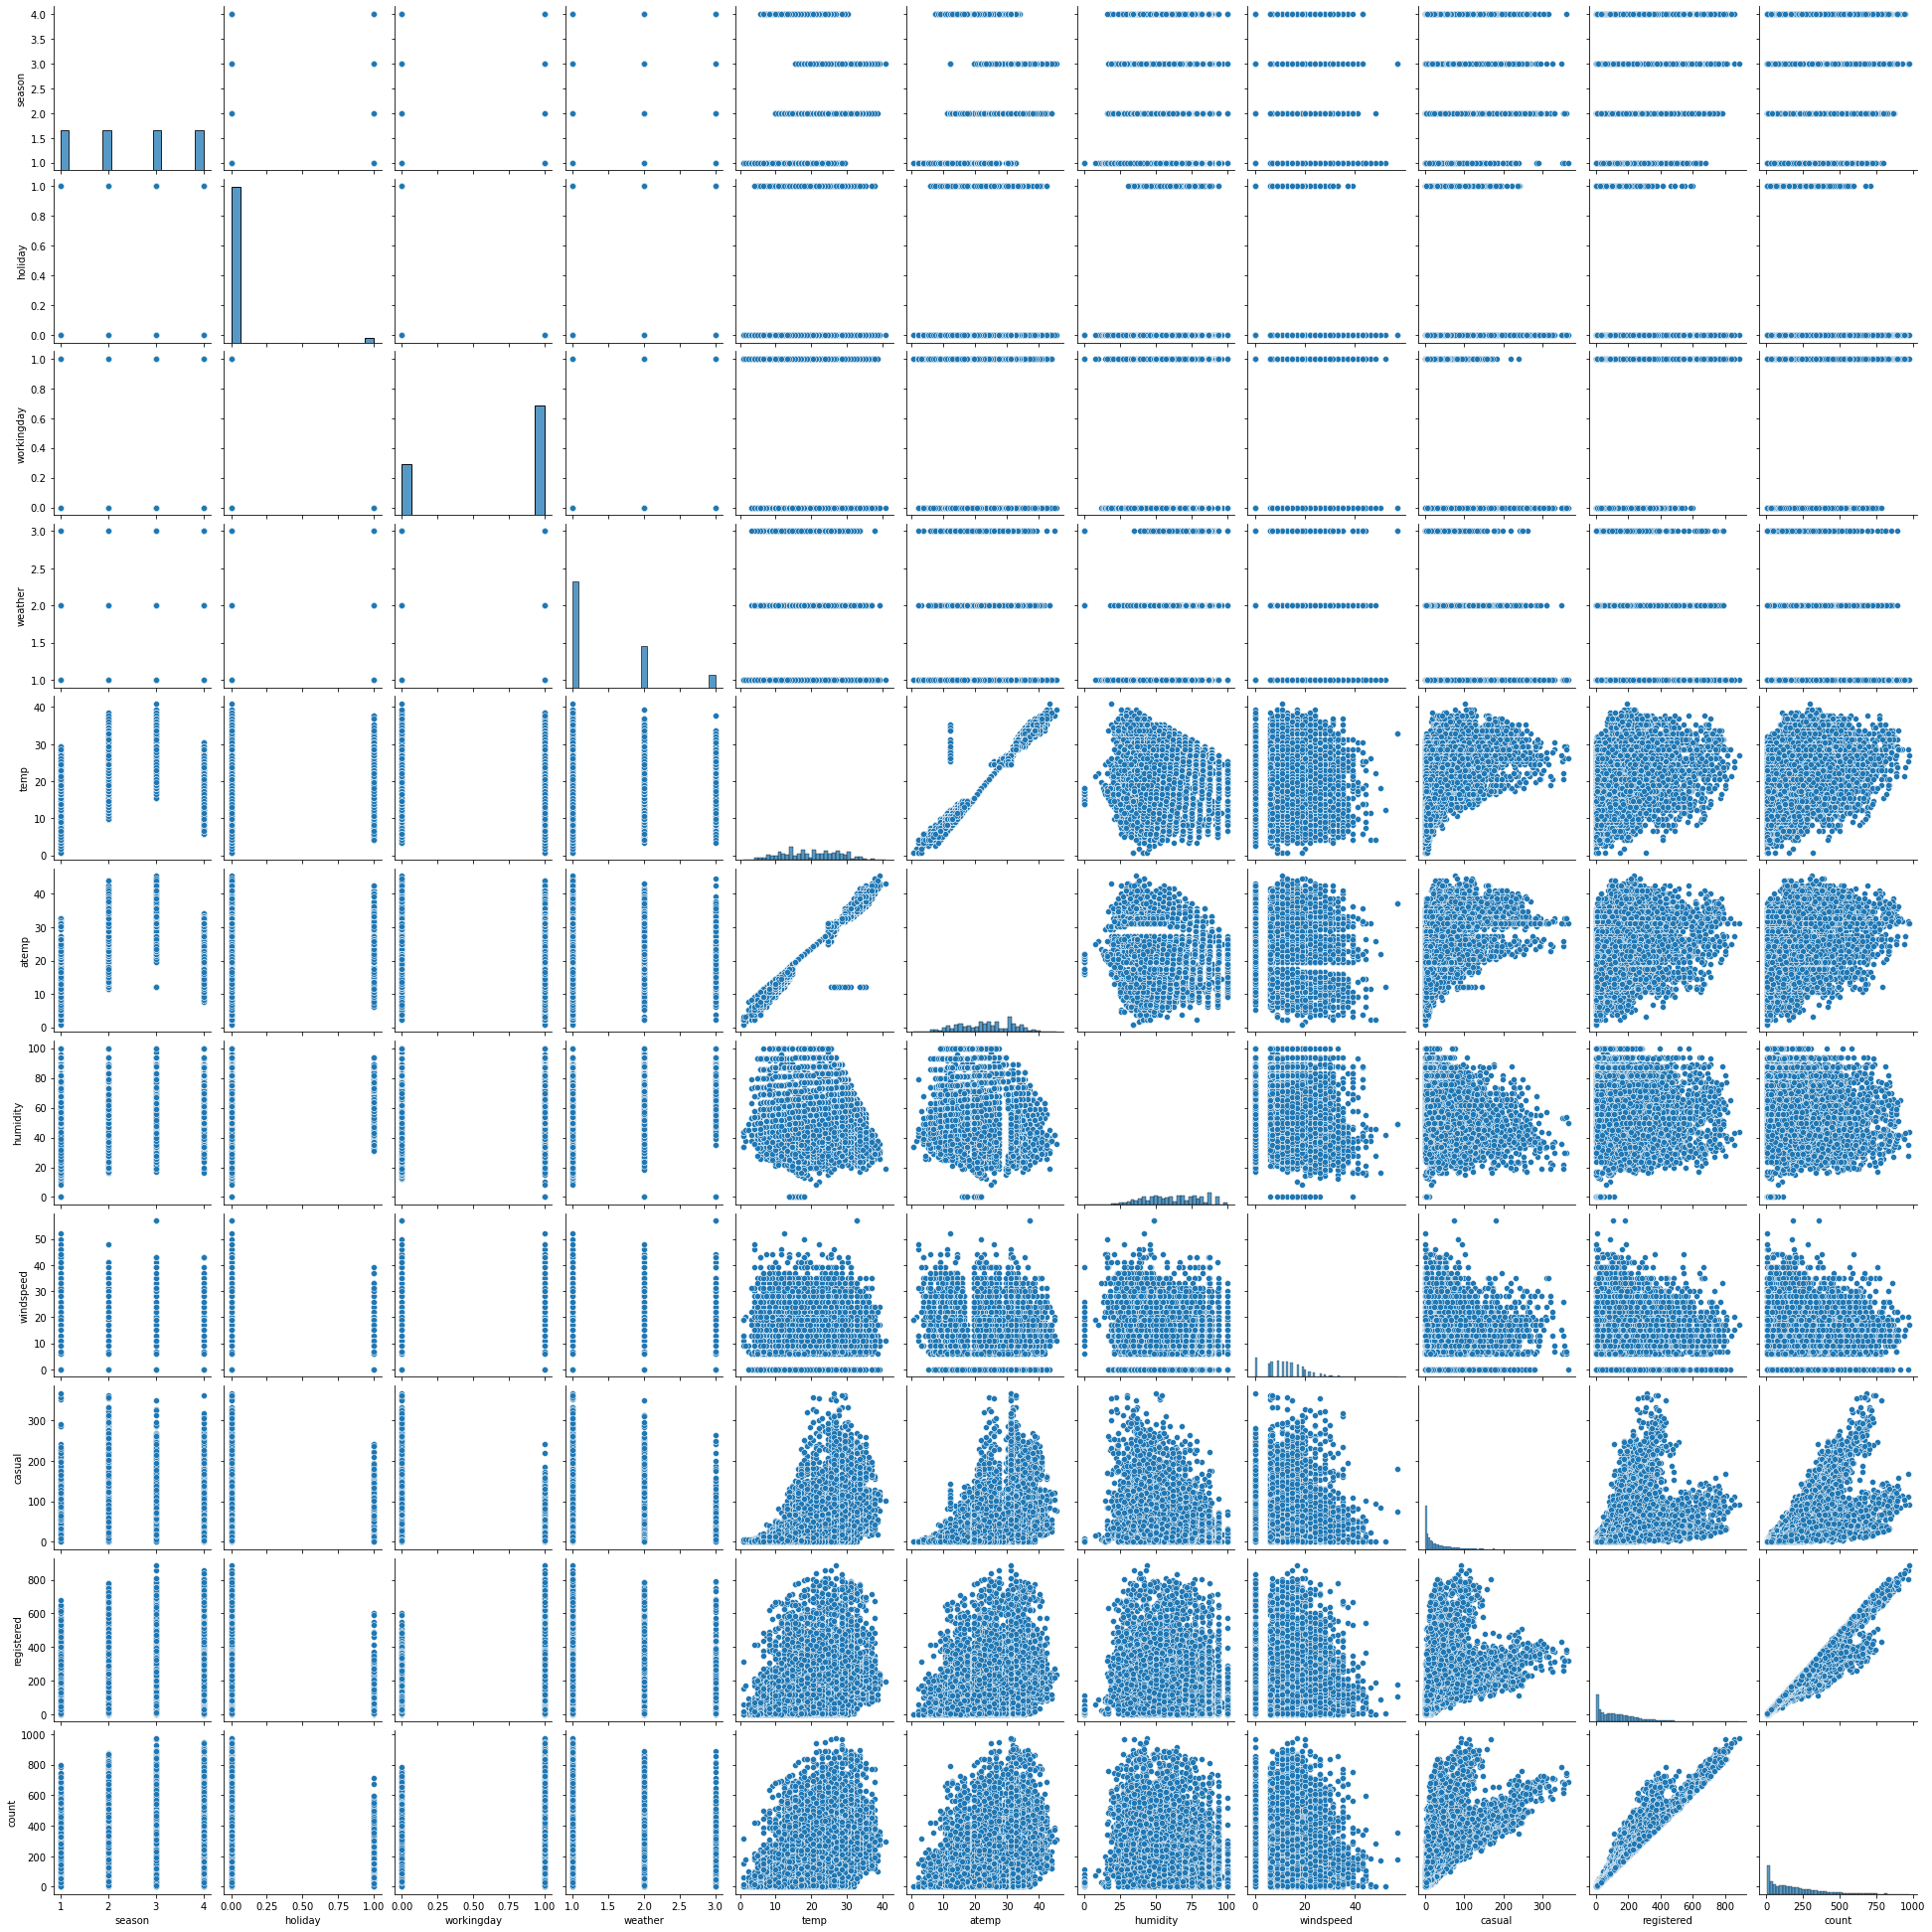

In [400]:
# grab numeric features


sns.pairplot(data = rentals)

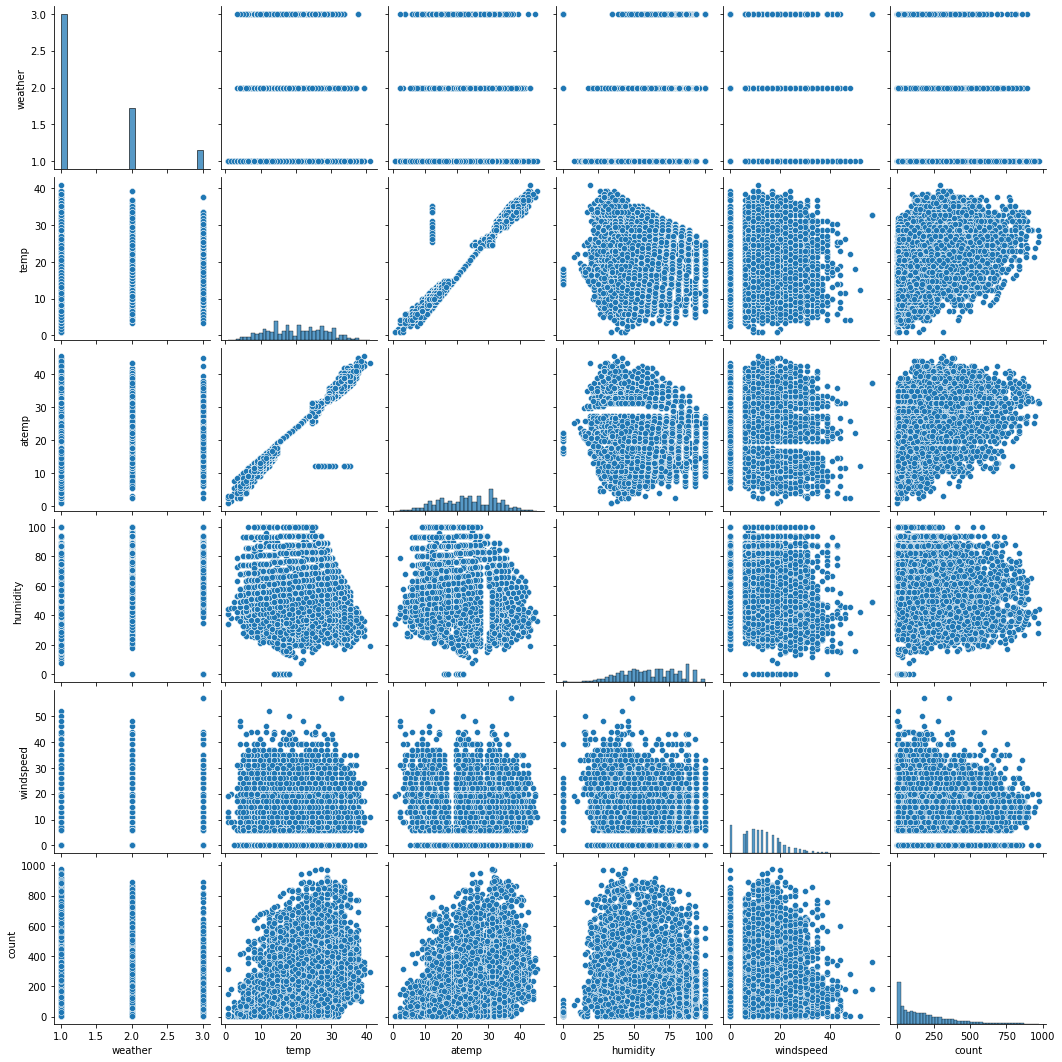

In [401]:

rentals_numerics = ['weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count']

sns.pairplot(data = rentals, vars = rentals_numerics)

/home/alex/.conda/envs/spiced/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


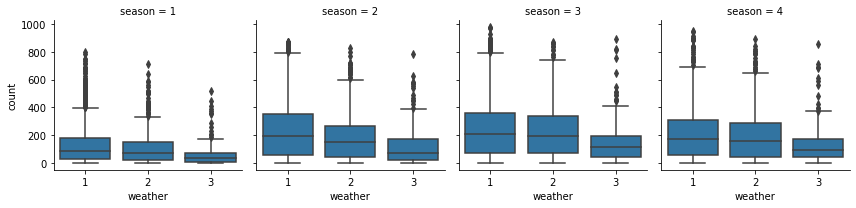

In [402]:
g = sns.FacetGrid(data = rentals[['weather', 'holiday', 'temp', 'windspeed', 'count', 'workingday', 'season']], col = 'season')
g.map(sns.boxplot,
    'weather',
    'count'


)

## Feature Engineering

- humidty = 0 at air temps above 12 degC are highly unlikely; remove obs or fill in with predicted values from temp

In [403]:
# from https://danvatterott.com/blog/2018/05/03/regression-of-a-proportion-in-python/ via
# https://stats.idre.ucla.edu/stata/faq/how-does-one-do-regression-when-the-dependent-variable-is-a-proportion/
import statsmodels.api as sm

humidity_clean = rentals.humidity[rentals.humidity > 1] / 100
temp_clean = rentals.temp[rentals.humidity > 1]

linear_glm = sm.GLM(humidity_clean, temp_clean)
linear_result = linear_glm.fit()
binom_glm = sm.GLM(humidity_clean, temp_clean, family=sm.families.Binomial())
binom_results = binom_glm.fit()


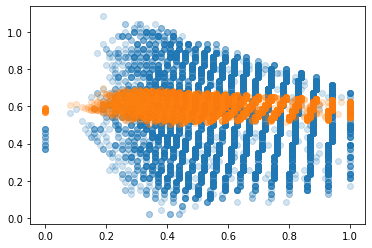

In [404]:
# plot results

rentals.humidity/100
plt.plot(rentals.humidity/100, linear_result.predict(rentals.temp), 'o', alpha=0.2)
plt.plot(rentals.humidity/100, binom_results.predict(rentals.temp), 'o', alpha=0.2)


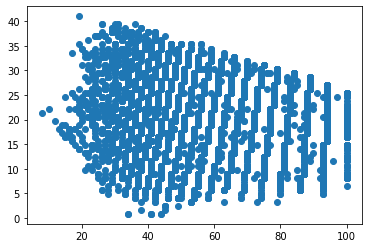

In [405]:

# binom results look too tightly constrained; using linear to replace humidty

rentals['humidity_adj'] = rentals.humidity

rentals.loc[rentals['humidity'] < 1, 'humidity_adj'] = linear_result.predict(rentals.loc[rentals['humidity'] < 1, 'temp'])*100


plt.plot(rentals.humidity_adj, rentals.temp, 'o')

<AxesSubplot:xlabel='windspeed', ylabel='Count'>

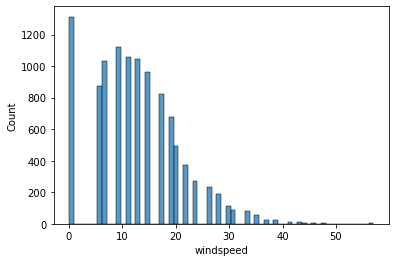

In [406]:
# inspect windspeed

sns.histplot(rentals, x = 'windspeed')

# could bin into calm < 5; 5 <= windy < 30; stormy >= 30

### Time features

- add Hour, Day, Month categories

In [407]:
# make function that cycles through time attrs and then adds a column to the df

def make_time_cols(time_att, time_series):
    
    feature_list = []

    for ta in time_att:
        try:

            dtobj = getattr(time_series, 'dt')

            feature_list.append(pd.Series(getattr(dtobj,ta), name = ta))
        except AttributeError:
            print(f'Time Attribute not present: {ta}')

    return pd.concat(feature_list, axis = 1)

In [408]:
time_atts = make_time_cols(time_att= ['year', 'dayofyear', 'month', 'day', 'weekday', 'hour'], time_series = rentals.datetime)

rentals = pd.concat([rentals, time_atts], axis = 1)



In [409]:
rentals.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,humidity_adj,year,dayofyear,month,day,weekday,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,81.0,2011,1,1,1,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,80.0,2011,1,1,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,80.0,2011,1,1,1,5,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,75.0,2011,1,1,1,5,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,75.0,2011,1,1,1,5,4


In [410]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      10886 non-null  datetime64[ns]
 1   season        10886 non-null  int64         
 2   holiday       10886 non-null  int64         
 3   workingday    10886 non-null  int64         
 4   weather       10886 non-null  int64         
 5   temp          10886 non-null  float64       
 6   atemp         10886 non-null  float64       
 7   humidity      10886 non-null  int64         
 8   windspeed     10886 non-null  float64       
 9   casual        10886 non-null  int64         
 10  registered    10886 non-null  int64         
 11  count         10886 non-null  int64         
 12  humidity_adj  10886 non-null  float64       
 13  year          10886 non-null  int64         
 14  dayofyear     10886 non-null  int64         
 15  month         10886 non-null  int64 

In [423]:
rentals.year.unique()

array([2011, 2012])

# Model Development

## Imports

In [439]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import r2_score

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


## Split Data

In [412]:
rentals.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'humidity_adj', 'year', 'dayofyear', 'month', 'day', 'weekday', 'hour'],
      dtype='object')

In [413]:
predictors = ['season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'humidity_adj',
       'year', 'dayofyear', 'month', 'day', 'weekday', 'hour']

outcome = ['count']

X_train, X_test, y_train, y_test = train_test_split(
    rentals[predictors],
    rentals[outcome],
    test_size = 0.3,
    random_state = 42)

## Make Transformation Pipeline

### Binning

In [414]:
from sklearn.base import BaseEstimator,TransformerMixin
class cut_transform(BaseEstimator,TransformerMixin) :

    def __init__(self, bins = [0, 20, 50, 100], labels = ['0-20]', '20-50]', '50-100]']):
        self.features = []
        self.bins = bins
        self.labels = labels
        
    def frame_cut(self, X, bins, labels, y = None):
        return X.apply(pd.cut, axis = 0, bins = bins, right=True, labels=labels)


    # not sure what fit should supply .. read up!
    def fit(self, X, y = None):
        self.frame_cut(X, bins = self.bins, labels = self.labels)
        return self
        
    def transform(self, X, y = None):
        self.features = [nm + "_binned" for nm in X.columns.tolist()]
        dout = self.frame_cut(X, bins = self.bins, labels = self.labels)
        dout.columns = self.features
        return dout

    def get_feature_names(self):
        return self.features



# cutter = cut_transform(bins = [-1, 10, 30, 1000], labels = ['calm', 'windy', 'stormy'])




### Cyclic features

In [415]:
def cyclic_trans(pds, cycle):
    # only use on a single feature column!
    #https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning/notebook
    out = pd.DataFrame(
        {pds.name + "_sin" : np.sin(2 * np.pi * pds/cycle),
         pds.name + "_cos" : np.cos(2 * np.pi * pds/cycle) 

        }
        
    )

    return out

# print(cyclic_trans(rentals[['hour']], 23).head())
print(cyclic_trans(rentals.hour, 23).head())

ctf_hour = FunctionTransformer(cyclic_trans, kw_args={'cycle' : 23})
ctf_month = FunctionTransformer(cyclic_trans, kw_args={'cycle' : 12})
ctf_weekday = FunctionTransformer(cyclic_trans, kw_args={'cycle' : 7})
ctf_season = FunctionTransformer(cyclic_trans, kw_args={'cycle' : 4})





   hour_sin  hour_cos
0  0.000000  1.000000
1  0.269797  0.962917
2  0.519584  0.854419
3  0.730836  0.682553
4  0.887885  0.460065


In [459]:
# num_features = ['temp', 'atemp', 'humidity', 'windspeed', 'weekday', 'hour', 'month']
# num_features_subset = ['atemp', 'windspeed', 'hour', 'humidity_adj']
num_features_subset = ['temp', 'humidity_adj']
# cat_features = ['workingday', 'holiday', 'weather']
cat_features = ['weather', 'workingday', 'holiday', 'year']

In [466]:

wind_pipe = make_pipeline(
    cut_transform(bins = [-1, 10, 35, 1000], labels = ['calm', 'windy', 'stormy']),
    OneHotEncoder(sparse = False, handle_unknown='ignore')
)



transformers = ColumnTransformer(
    transformers = [
        ('hour_trans', ctf_hour, 'hour'),
        ('month_trans', ctf_month, 'month'),
        ('week_trans', ctf_weekday, 'weekday'),
        ('season_trans', ctf_season, 'season'),
        ('wind_trans', wind_pipe, ['windspeed']),
        # ('year_pass', 'passthrough', ['year']),
        ('scale_num', StandardScaler(), num_features_subset),
        ('one_hot', OneHotEncoder(sparse = True, handle_unknown='ignore'), cat_features)
    ],
    remainder = 'drop'
)


make_model = make_pipeline(
    
        transformers,
        PoissonRegressor()
        # LinearRegression()
        
)



pomod = make_model.fit(X_train, y_train.values.ravel())



In [467]:
print(round(pomod.score(X_train, y_train.values.ravel()),2) , round(pomod.score(X_test, y_test.values.ravel()),2))



# mean_poisson_deviance(y_train, pomod.predict(X_train))
r2_score(y_train, pomod.predict(X_train))


0.51 0.52


0.45488608867299674

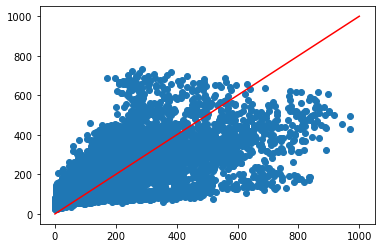

In [468]:
plt.scatter(y_train.values.ravel(), pomod.predict(X_train))
plt.plot([0,1000], [0,1000], c = 'red')
